# Segmetador para pelotas de golf

## 1. Integrantes del grupo

Esta práctica ha sido elaborada por el grupo 19 equipo 2, formado por los estudiantes:
* Sergio Álvarez López
* Mario Hernández García
* José Del Castillo Izquierdo
* Nicolás Forero Arévalo
* Álvaro Martín Jiménez

## 2. Objetivos

El objetivo de esta actividad es poder separar pelotas de golf de su respectivo background en una imagen mediante el uso de segmentadores. En concreto utilizaremos un segmentador construido a partir de la suma de segmentadores.

Hemos aplicado distintos segmentadores ya creados y el resultado final de nuestro segmentador se decidirá en función de lo que estos segmentadores obtengan. 

El caso al que lo aplicamos, el de las pelotas de golf, puede ser de gra utilidad. Es habitual en el golf que se pierdan pelotas entre el cesped debido a las grandes tamaños de los campos en los que se juega. Es por eso que un segmentador que sea capaz de reconocer pelotas de golf entre el cesped puede ser de gran utilidad para recuperarlas todas.

## 3. Conjunto de imágenes a corregir

En nuestro conjunto de imagenes hemos trabajado sobretodo con imagenes en las que se observa claramente la pelota sobre el cesped, que será el background más habitual. 

Hemos probado diferentes numeros de pelotas, solapamientos y con algún otro objeto a parte en la imagen. De esta manera podemos estudiar que tan fiable es nuestro segmentador y cuales pueden ser los puntos débiles que debamos tener en cuenta.

## 4. Solución propuesta

Como hemos comentado anteriormente, nuestro segmentador se basa en la unión de varios segmentadores. En concreto, hemos utilizado el método de k-means, watershed y quickshift.

Estos segmentan la imagen de forma independiente, asignando la etiqueta 0 al background y 1 a lo que considera pelota de golf. Una vez ejecutados los segmentadores, sumamos una unidad cada vez que dos segmentadores coinciden. De esta manera, si hay tres segmentadores que estan de acuerdo, la daremos por buena. 

## 5. Ejecución paso a paso del algoritmo comentada

Primeramente ejecutamos todos los import necesarios. Muestro aquí una lista de todos ellos así como sus principales usos.

* matplotlib - generación de las imágenes a partir de las matrices
* numpy - manejo de las matrices que representan las imágenes
* skimage - manejo de las imágenes, desde su carga hasta el paso de espacio entre colores (RGB, HSV)
* urllib - importación de imágenes vía url
* os - importación de imágenes desde un fichero local

In [1]:
import warnings
warnings.filterwarnings('ignore')

from scipy import ndimage as ndi

from skimage import measure
from skimage import io
from skimage import color
from skimage.segmentation import mark_boundaries
from skimage.segmentation import quickshift
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.morphology import disk
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
import cv2
import skimage.io
import os
import matplotlib.pyplot as plt
import numpy as np
import time

## Consideraciones generales

A lo largo de todo el trabajo iremos evaluando tanto los clasificadores por separado como el clasificador final formado por la unión del resto.

La función de evaluación tiene en cuenta las métricas propias de los problemas de clasifación que surgen de la matriz de confusión. Las métricas calculadas se pueden ver la definición de la siguiente celda:

In [2]:
def evaluacion(imagen_umbralizada,Ground_truth):
    TN=0
    TP=0
    FP=0
    FN=0

    imagen_umbralizada= np.uint8(imagen_umbralizada)
    width, height = imagen_umbralizada.shape
    for x in range(width-1):
        for y in range(height-1):

            if imagen_umbralizada[x][y] == 0 and Ground_truth[x][y]== 0:
                TN=TN+1
            elif imagen_umbralizada[x][y] == 255 and Ground_truth[x][y]== 255:
                TP=TP+1
            elif imagen_umbralizada[x][y] == 255 and Ground_truth[x][y]== 0:
                FP=FP+1
            elif imagen_umbralizada[x][y] == 0 and Ground_truth[x][y]== 255:
                FN=FN+1

    acuraccy= (TP+TN)/(TP+TN+FP+FN)
    error_rate= (FP+FN)/(TP+TN+FP+FN)
    specificity = TN/(TN+FP)
    sensitivity=TP/(TP+FN)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    F1_score=(2*TP)/(2*TP+FP+FN)

    return print('Los resultados para el segmentador obtenidos son: ',
                 'acuraccy: ',acuraccy, '\n',
                 'error_rate: ',error_rate,'\n',
                 'specificity: ',specificity,'\n',
                 'sensitivity: ',sensitivity,'\n',
                 'precision: ',precision,'\n',
                 'recall: ', recall,'\n',
                 'F1 score: ',F1_score,'\n',
                 'Tasa de Verdaderos Positivos: ', TP,'\n',
                 'Tasa de Verdaderos Negativos: ', TN,'\n',
                 'Tasa de Falsos Positivas: ', FP,'\n',
                 'Tasa de Falsos Negativos: ', FN)

## Módulo input

In [3]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(11,11))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()



En este momento, el usuario decide a qué imagen le quiere aplicar la corrección.

Finalmente, se muestra en gran tamaño la imagen original sobre la que se aplicara la segmentación.

Introduzca el nombre de la imagen que desee ver (tres pelotas, 3 pelotas con hoyo, 5 pelotas, dos pelotas, pelotas con tubo o pelota con hoyo).
Nombre de la imagen(sin extensión): 5 pelotas


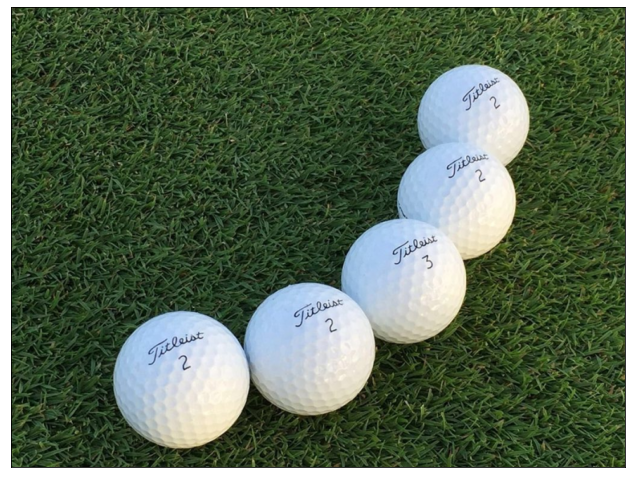

In [66]:
#Para que funcione se deben tener las imágenes descargadas de  github en el almacenamiento interno

print("Introduzca el nombre de la imagen que desee ver (tres pelotas, 3 pelotas con hoyo, 5 pelotas, dos pelotas, pelotas con tubo o pelota con hoyo).")



list_images = os.listdir("images")
data_files = {}

for filename in list_images:
    data_files[filename.split(".")[0]] = filename.split(".")[1]


while 1:
    image_name = input("Nombre de la imagen(sin extensión): ")
    


    #si nuestro archivo está en la carpeta local
    if image_name !='':

        data_dir = 'images/'

        if image_name in data_files.keys():
            image_path = os.path.join(data_dir,  image_name + '.' + data_files[image_name])
            image_gt_path = os.path.join(data_dir,  image_name + ' GT.' + data_files[image_name])
            image = io.imread(image_path)
            image = image[:,:,:3] # excluimos el canal alpha si lo hubiese
            gray = color.rgb2gray(image)
            image_gt = io.imread(image_gt_path)
            if len(image_gt.shape) == 3:
                image_gt = image_gt[:,:,0] 
            break
        else:
            print("\nNo se encuentra la imagen introducida por la entrada. Vuelva a introducir el nombre de la imagen\n")
            continue

    
imshow(image)

## Implementación de meanshift

En la siguiente celda buscamos los parámetros más óptimos para este clasificador. Recordemos que este clasificador se basa en una versión que extiende al algoritmo MeanShift que implementa kernels.

Las ideas que nos han llevado a elegir los siguientes valores para los parámetros son las que siguen:
* ratio: Recordemos que este algoritmo se basa tanto en los colores como en la localización de los píxeles. El parámetro ratio define el balance entre la importancia que se le da a la posición de los píxeles frente al color de estos. De esta manera, cuanto más cerca está el ratio de 1, más peso cobrarán los colores de los píxeles en detrimento del factor de la distancia. Es por esto que el valor elegido está tan cercano a uno, para aprovechar el hecho de que el objeto de interés es de un color muy diferente al del fondo.
* kernel_size: Antes de aplicar el algoritmo de clusterización, se realiza un filtro gaussiano con el objetivo de suavizar la imagen. Es por ello que a mayor tamaño del kernel, menores clústeres obtendremos. Como en las primeras pruebas salían más de 1000 clústeres, optamos por aumentar el tamaño del kernel como contramedida a la sobresegmentación que se producía en el cesped (que cuenta con cantidad de detalles que confundían al clasificador)
* max_dist: Distancia máxima que se tiene en cuenta para la generación de clústeres. A mayor tamaño, menos clústeres (ya que se suaviza la restricción temporal). Es por ello que aumentamos el valor hasta 20.
* sigma: ancho de la suavización gaussian. Elegimos un ancho notable para que esta aumentara su efecto.
* convert2lab: en la documentación oficial se aboga por pasar la imagen de RGB al espacio de color Lab antes de la segmentación, es por ello que lo fijamos a True


Tengamos en mente que el resultado de este clasificador no será la segmentación final sino una sobresegmentación que luego deberá ser unida de un modo específico.

In [67]:
start = time.time()

segments_quick = quickshift(image, 
                            ratio=0.9,
                            kernel_size=20,
                            max_dist=20,
                            sigma = 5,
                            convert2lab=True,
                            random_seed=25
                            )
end = time.time()

total_time = end - start

print("Quickshift ha tardado ", total_time, " segundos en generar la sobresegmentación.")

print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

Quickshift ha tardado  112.10708904266357  segundos en generar la sobresegmentación.
Quickshift number of segments: 70


En la celda de abajo podemos ver la sobresegmantación generada por el algoritmo quickshift.

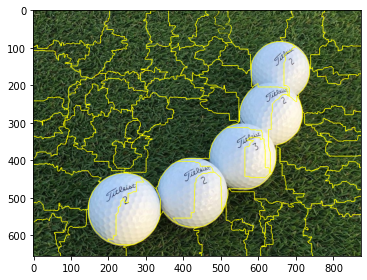

In [68]:
plt.imshow(mark_boundaries(image, segments_quick))
plt.tight_layout()
plt.show()

Como hemos comentado, este algoritmo genera una sobresegmentación. Es por ello que es necesaria conseguir juntar estos segmentos generados en base a algún criterio. Nosotros usaremos el conocido método de IA llamado K-means.

Primeramente, con fines ilustrativos, coloreamos cada uno de los segmentos generados por nuestro algoritmo. Resaltando así la clara sobresegmentación que hemos obtenido.

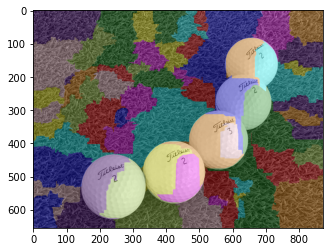

In [69]:
labels = segments_quick
plt.imshow(color.label2rgb(labels, image=image))

Ahora, coloreamos cada segmento en base a su valor medio, consiguiendo así un idea de una posible unión de nuestros segmentos. En estos casos ya somos capaces de ver que las pelotas de golf serán correctamente segmentadas si se unen los subsegmentos oportunos.

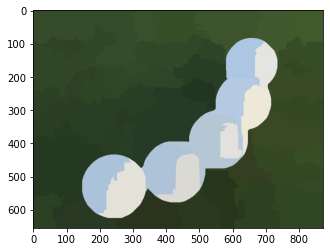

In [70]:
plt.imshow(color.label2rgb(labels, image=image, kind='avg'), cmap = 'gray')

Para facilitar los cálculos posteriores, pasamos esta segmentación y sus imágenes a una escala de grises.

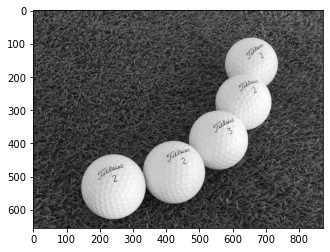

In [71]:
gray_image = rgb2gray(image)
regions = measure.regionprops(labels, intensity_image=gray_image)
plt.imshow(gray_image, cmap=plt.cm.gray)

De nuevo, con fines ilustrativos, realizamos la misma idea que antes de calcular la media de la intensidad de cada región pero ahora en escala de grises. Como resultado, podemos calcular el correspondiente histograma.

Gracias a este histograma es claro que existen dos tipos de segmentos, los correspondientes a las pelotas de golf y los correspondientes al fondo.

Ahora, ya estaríamos en la posición de elegir un umbral en el histograma como criterio de unión de los segmentos de la sobresegmentación, resultando así en dos segmentos finales (las clasificaciones de la pelota y del fondo respectivamente).

(array([19., 25., 12.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  3.,  2.,  0.,  1.,  4.]),
 array([0.18854394, 0.22468206, 0.26082018, 0.2969583 , 0.33309642,
        0.36923454, 0.40537266, 0.44151078, 0.4776489 , 0.51378702,
        0.54992514, 0.58606326, 0.62220138, 0.6583395 , 0.69447762,
        0.73061574, 0.76675386, 0.80289198, 0.8390301 , 0.87516822,
        0.91130634]),
 <BarContainer object of 20 artists>)

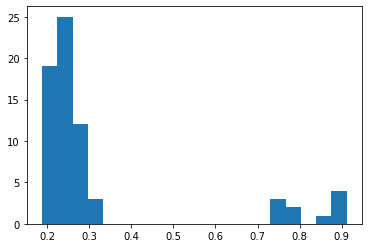

In [72]:
region_means = [r.mean_intensity for r in regions]
plt.hist(region_means, bins=20)

Nótese que este desarrollo se ha llevado a cabo con fines ilustrativos y didácticos ya que la elección del umbral es algo que debe automatizarse, por lo que la visualización del histograma no es algo que podamos implementar en el flujo de este trabajo.

Para automatizar la elección de este umbral, vamos a utilizar el conocido algoritmo K-means, especificando K = 2, para que nos genere dos clústeres y a partir de ahí pueda definir un criterio para aunar los numerosos segmentos de la sobresegmenración.

In [73]:
model = KMeans(n_clusters=2)

region_means = np.array(region_means).reshape(-1, 1)
model.fit(region_means)
print(model.cluster_centers_) #obtenemos los centros de los dos clusters

[[0.2411114 ]
 [0.82512291]]


Obtenemos las etiquetas de cada una de los segmentos de la sobresegmentación de manera que terminamos obteniendo dos únicas clases. Es decir, acabamos de obtener un mapeo entre los segmentos de la sobresegmentación y las dos clases finales.

In [74]:
bf_fg_labels = model.predict(region_means)
bf_fg_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

A continuación etiquetamos cada píxel en una de las dos clases, pelota o fondo, en base a su segmento de la sobresegmentación inicial y aplicando el mapeo de la celda anterior.

In [75]:
classified_labels = labels.copy()
for bf_fg, region in zip(bf_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bf_fg

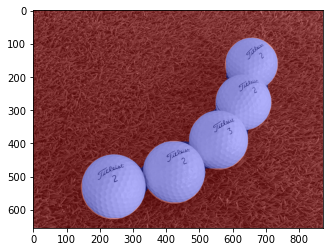

In [76]:
plt.imshow(color.label2rgb(classified_labels, image = image))

Finalmente pasamos la imágen de las clases a una escala umbralizada de blancos y negros para que sirva como input a nuestro sistema de votación.

In [77]:
quickshit_ouput = classified_labels * 255

In [78]:
quickshift_output = classified_labels.copy()

In [79]:
max_x, max_y = quickshift_output.shape

for i in range(0, max_x):
    for j in range(0, max_y):
        quickshift_output[i][j] = quickshift_output[i][j] * 255 

In [80]:
quickshift_output.shape

(655, 873)

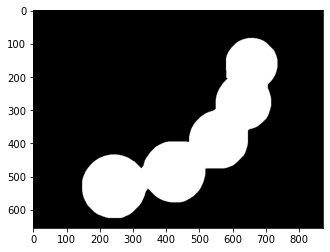

In [81]:
plt.imshow(quickshift_output, cmap=plt.cm.gray)

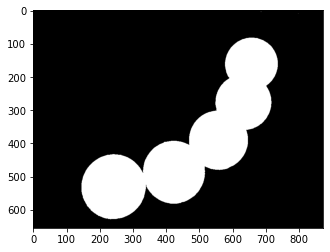

In [82]:
plt.imshow(image_gt, cmap=plt.cm.gray)

Pasemos ahora a evaluar el rendimiento de este clasificador cuando se considera de manera individual.

In [83]:
evaluacion(quickshift_output, image_gt)

Los resultados para el segmentador obtenidos son:  acuraccy:  0.995358461120317 
 error_rate:  0.004641538879682966 
 specificity:  0.9985996683308929 
 sensitivity:  0.9827770691913269 
 precision:  0.994499497591906 
 recall:  0.9827770691913269 
 F1 score:  0.9886035347555594 
 Tasa de Verdaderos Positivos:  114809 
 Tasa de Verdaderos Negativos:  452829 
 Tasa de Falsos Positivas:  635 
 Tasa de Falsos Negativos:  2012


-------------------

## Implementación Watershed

Antes de aplicar el segmentador, usamos un filtro de media para eliminar el ruido y lograr así mejores resultados

In [84]:
denoised = rank.median(gray, disk(2))

El siguiente segmentador se trata de el metodo watershed. En este segmentador colocamos distintas semillas en la imagen que se irán expandiendo hasta abarcar una zona de la imagen. Cada zona tendrá una etiqueta. Para aplicar este segmentador nos hemos basado en la siguiente página web: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_marked_watershed.html

Las semillas las colocaremos en los puntos más continuos de la imagen, en aquellos cuyo gradiente sea menor a 20. Esto se debe a que podemos sospechar que las zonas continuas seran el mismo objeto, y así nos ahorramos problemas como que haya muchas semillas en un mismo objeto al que etiquetar o que no haya. El valor 20 se ha escogido porque es el valor por el cual obtenemos un mejor resultado general para el conjunto de imagenes, pese a que hay valores mejores para cada imagen de forma individual.

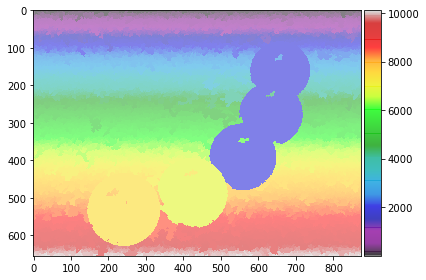

In [85]:
#Definimos las semillas
markers = rank.gradient(denoised, disk(2)) < 20
markers = ndi.label(markers)[0]

#Calculamos el gradiente
gradient = rank.gradient(denoised, disk(2))

#Utilizamos el metodo watershed para obtener la imagen segmentada
labels = watershed(gradient, markers)


skimage.io.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)


Observamos las distintas etiquetas aplicadas a la imagen representados por distintos colores.

Una vez etiquetada la imagen, pasamos esas etiquetas a blanco y negro.

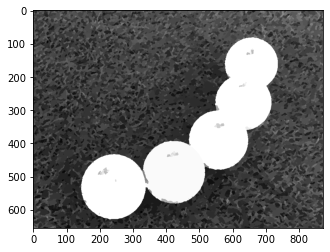

In [86]:
final = color.label2rgb(labels, image = denoised, kind = 'avg')
final_gray = rgb2gray(final)
plt.imshow(final_gray,cmap=plt.cm.gray)

Umbralizamos las etiquetas: todo valor por encima de 190 será marcado como 255, lo restante como 0. De nuevo, el valor 190 ha sido escogido porque es el que mejores resultados de imagenes obtenemos con el conjunto de imagenes usado.

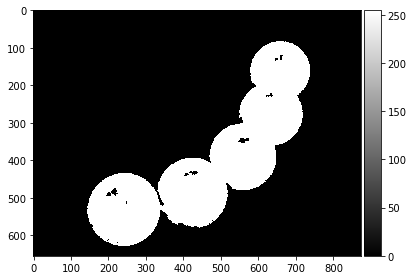

In [87]:
watershed_output = np.where(final_gray < 190, 0, 255)

skimage.io.imshow(watershed_output,cmap=plt.cm.gray)

Pasemos ahora a evaluar el rendimiento de este clasificador cuando se considera de manera individual.

In [88]:
evaluacion(watershed_output, image_gt)

Los resultados para el segmentador obtenidos son:  acuraccy:  0.9951042022848225 
 error_rate:  0.004895797715177499 
 specificity:  0.9988797346647142 
 sensitivity:  0.9804487206923412 
 precision:  0.9955843365639533 
 recall:  0.9804487206923412 
 F1 score:  0.987958562273037 
 Tasa de Verdaderos Positivos:  114537 
 Tasa de Verdaderos Negativos:  452956 
 Tasa de Falsos Positivas:  508 
 Tasa de Falsos Negativos:  2284


-------------------

## Implementación segmentador K-means

Utilizamos la segmentación con kmeans para hacer una cuantización del color. Debido a que las pelotas son de color blanco y el resto (background) suele ser de color verde, se esperan unos buenos resultados. 


Tenemos 3 canales, R, G y B. Reajustamos la imagen de manera que sea de tamaño Mx3 (siendo M el numero de pixeles de la imagen, reultado de la multiplicación de ancho por el alto). Al segmentador debemos indicarles cuántos clusteres queremos que haga y el criterio de buqueda. Cuando ese criterio es satisfecho, la función para y nos devulve como retultado las etiquitas y el valor de los centros de cada uno de los clusteres.

Utilizamos un filtro de mediana para evitar ruido en la imagen  y para eliminar las letras de las pelotas de golf

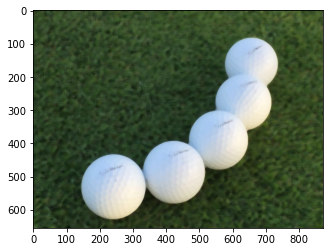

In [89]:
image = cv2.medianBlur(image,11)
plt.imshow(image)
#hacemos el reajuste mencionado anteriormente
Z = image.reshape((-1,3))

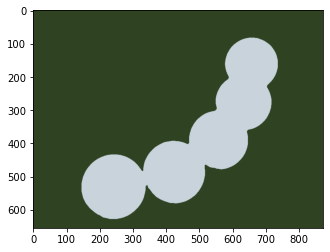

In [90]:
# Lo convertimos en np.float32 tal y como se especifica en la documentación de open CV
Z= np.float32(Z)

# definimos el criterio de busqueda de los clusters y el números de clusters total que queremos
#tener como resultado . Aplicamos Kmeans.

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
ret,label,center=cv2.kmeans(Z,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)


# Utilizamos los centros (valor central de cada cluster) para crear nuestra imagen resultado, que
# tendremos que volverla a cambiar su forma para tener 3 canales

center=np.uint8(center)


res = center[label.flatten()]
res2 = res.reshape((image.shape))

plt.imshow(res2)

Pasamos la imagen a blanco y negro\n y aplicamos la umbralización final para ponerlo en dos categorías

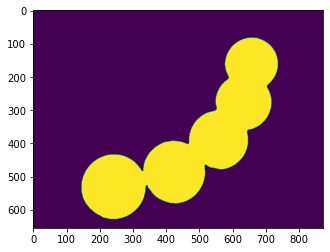

In [91]:
res2 = color.rgb2gray(res2)
_, umbralizada = cv2.threshold(res2, 0.5, 255, cv2.THRESH_BINARY)
plt.imshow(umbralizada)

Esta función compara la imagen umbralizada obtenida por el segmentador y la compara con la imagen de 

In [92]:
kmeans_output = umbralizada
evaluacion(kmeans_output, image_gt)

Los resultados para el segmentador obtenidos son:  acuraccy:  0.9980132740647221 
 error_rate:  0.0019867259352779752 
 specificity:  0.9995545401619533 
 sensitivity:  0.9920305424538396 
 precision:  0.9982600006891086 
 recall:  0.9920305424538396 
 F1 score:  0.9951355227059031 
 Tasa de Verdaderos Positivos:  115890 
 Tasa de Verdaderos Negativos:  453262 
 Tasa de Falsos Positivas:  202 
 Tasa de Falsos Negativos:  931


-------------------

## Unión de clasificadores por sistema de votación.

Ahora procedemos a reunir todos las imágenes que hemos procesado con los diferentes segmentadores para hacer un sistema de votación y quedarnos con el voto mayoritario.

Al disponer de 3 segmentadores, generaremos el resultado contando con la premisa de que al menos, 2 de los 3 segmentadores han tenido que detectar la posición de las pelotas de golf.

Para ello recorremos cada matriz pixel a pixel y comparamos cada una de las imágenes con las otras restantes. Si un pixel es igual a otro, se general otra imagen en la que sumamos 1 a modo de contador.

Por ultimo, hacemos una umbralización binaria de la imágen para que a partir de dos partes coincidentes se represent con el valor 255 (existe pelota de golf) y 0 en el caso contrario (asumimos que es background)



In [93]:
def segmentacion_final(imagen_umbralizada1, imagen_umbralizada2, imagen_umbralizada3):

    width, height = imagen_umbralizada1.shape
    votacion = np.zeros((width,height),np.uint8)

    for x in range(width-1):
        for y in range(height-1):
            if imagen_umbralizada1[x][y] == imagen_umbralizada2[x][y] and imagen_umbralizada1[x][y]==255:
                votacion[x][y] = votacion[x][y]+1
            if imagen_umbralizada2[x][y]== imagen_umbralizada3[x][y] and imagen_umbralizada2[x][y]==255:
                votacion[x][y] = votacion[x][y]+1
            if imagen_umbralizada3[x][y]== imagen_umbralizada1[x][y] and imagen_umbralizada3[x][y]==255:
                votacion[x][y] = votacion[x][y]+1

    _ , final_umbralizada= cv2.threshold(votacion, 0.5, 255, cv2.THRESH_BINARY)
    return final_umbralizada

In [94]:
final_output = segmentacion_final(quickshift_output, watershed_output, kmeans_output)

In [95]:
evaluacion(final_output, image_gt)

Los resultados para el segmentador obtenidos son:  acuraccy:  0.9979413801870994 
 error_rate:  0.0020586198129005674 
 specificity:  0.9995126404742163 
 sensitivity:  0.9918422201487747 
 precision:  0.9980962881926797 
 recall:  0.9918422201487747 
 F1 score:  0.9949594263878752 
 Tasa de Verdaderos Positivos:  115868 
 Tasa de Verdaderos Negativos:  453243 
 Tasa de Falsos Positivas:  221 
 Tasa de Falsos Negativos:  953


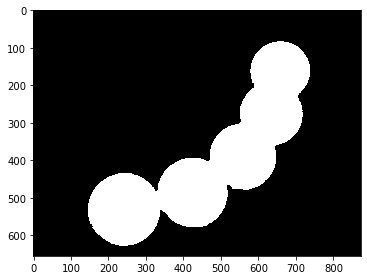

In [96]:
skimage.io.imshow(final_output,cmap=plt.cm.gray)

## Conclusiones

Después de realizar varios segmentadores, evaluarlos frente al ground truth y realizar un segmentador agregado a través de un sistema de votación, podemos decir que hemos conseguido completar el objetivo de segmentar unas bolas de golf sobre césped verde de manera notable.

Cabe destacar que, aunque en la actividad solo hayamos introducido tres segmentadores para hacer la votación final, se ha estado también investigando con otros, como pueden ser felzenszwalb o la búsqueda de parámetros a través de una optimización bayesiana.

También es reseñable que, aunque los segmentadores individuales conseguían buenos resultados en cuanto a su evaluación, en el segmentador agregado se ha incrementado su acierto prácticamente en todos los aspectos, haciéndolo una opción muy recomendable para resolver el problema que planteábamos.